In [31]:
## import library

import torch

In [32]:
# initial device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use cpu or gpu for training


In [33]:
# create custom cifar class for the dataset directory
import pandas as pd
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
from torch import tensor
class CIFARDataset(Dataset):
    def __init__(self, img_dir, labels_file=None, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = None
        
        if labels_file:
            labels_df = pd.read_csv(labels_file)
            unique_labels = labels_df["label"].unique()
            self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
            self.file_paths = [os.path.join(img_dir, f"{img_id}.png") for img_id in labels_df["id"]]
            self.labels = [self.label_mapping[label] for label in labels_df["label"]]
        else:
            self.file_paths = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir)])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = read_image(img_path).float() / 255.0  #normalize to [0, 1]
        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = tensor(self.labels[idx])
            return image, label
        return image

In [34]:
# transform data
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [35]:
# load dataset
from torch.utils.data import DataLoader, random_split
train_data = CIFARDataset(img_dir="cifar-10/train", labels_file="cifar-10/trainLabels.csv", transform=transform_train)
test_data = CIFARDataset(img_dir="cifar-10/test", transform=transform_test)

# split train data into traiung and validating set
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

trainloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)


In [36]:
# initialize the models
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
model_name = 'resnet18'

print(f"training model {model_name}")
# select the model resnet18
model = models.resnet18(pretrained = False)
model.fc = nn.Linear(512,10) # configuration for resnet18 model
model.to(device)



training model resnet18


/home/kubuntu/Desktop/repos/fundamental_ml/fundamental_ml_assignment_2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kubuntu/Desktop/repos/fundamental_ml/fundamental_ml_assignment_2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
# train model 
def validate_model(model, criterion, valloader):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    val_loss = val_loss / len(testloader) if total >0 else None
    val_acc = 100. * correct / total if total > 0 else None
    return val_loss, val_acc

def train_model ( model, criterion, optimizer, num_epochs = 10):
    # function to train t he model
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss.append(running_loss / len(trainloader))
        train_acc.append(100. * correct / total)

        val_loss_epoch, val_acc_epoch = validate_model(model, criterion, valloader)
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch)
        # Adjust print to handle None values for validation loss and accuracy
        val_loss_str = f"{val_loss[-1]:.4f}" if val_loss[-1] is not None else "N/A"
        val_acc_str = f"{val_acc[-1]:.2f}%" if val_acc[-1] is not None else "N/A"
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]:.4f}, Acc: {train_acc[-1]:.2f}%, '
              f'Val Loss: {val_loss_str}, Val Acc: {val_acc_str}')


    return train_loss, train_acc, val_loss, val_acc

results = {}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 1.5984, Acc: 41.49%, Val Loss: 0.0505, Val Acc: 45.33%
Epoch 2/10, Loss: 1.2595, Acc: 54.92%, Val Loss: 0.0409, Val Acc: 56.97%
Epoch 3/10, Loss: 1.0921, Acc: 60.81%, Val Loss: 0.0350, Val Acc: 63.34%
Epoch 4/10, Loss: 0.9844, Acc: 65.05%, Val Loss: 0.0329, Val Acc: 65.41%
Epoch 5/10, Loss: 0.9049, Acc: 68.02%, Val Loss: 0.0316, Val Acc: 66.90%
Epoch 6/10, Loss: 0.8520, Acc: 70.01%, Val Loss: 0.0289, Val Acc: 69.29%
Epoch 7/10, Loss: 0.7939, Acc: 72.36%, Val Loss: 0.0270, Val Acc: 71.94%
Epoch 8/10, Loss: 0.7530, Acc: 73.71%, Val Loss: 0.0276, Val Acc: 71.29%
Epoch 9/10, Loss: 0.7217, Acc: 74.87%, Val Loss: 0.0276, Val Acc: 70.81%
Epoch 10/10, Loss: 0.6851, Acc: 76.02%, Val Loss: 0.0273, Val Acc: 71.40%


In [38]:
# print the result 
results[model_name] = {
    "train_loss": train_loss,
    "train_acc": train_acc,
    "val_loss": val_loss,
    "val_acc": val_acc
}
print(results)

{'resnet18': {'train_loss': [1.5983506901957356, 1.2595112822688044, 1.0921104613203592, 0.9844047490019388, 0.9048640752752749, 0.8520455670813782, 0.7938513321617541, 0.7530090629864044, 0.7217265993071059, 0.6850885511777652], 'train_acc': [41.49, 54.9175, 60.81, 65.045, 68.0225, 70.0125, 72.365, 73.7075, 74.87, 76.0175], 'val_loss': [0.050451485827921194, 0.040853631832087, 0.035045663880203366, 0.032868221097025044, 0.03164260569998022, 0.028872876291388943, 0.02697565821047122, 0.027643828846692226, 0.027605930769199396, 0.027335724351552567], 'val_acc': [45.33, 56.97, 63.34, 65.41, 66.9, 69.29, 71.94, 71.29, 70.81, 71.4]}}


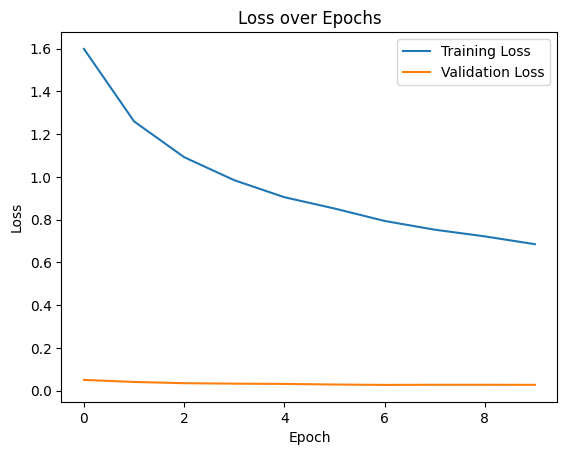

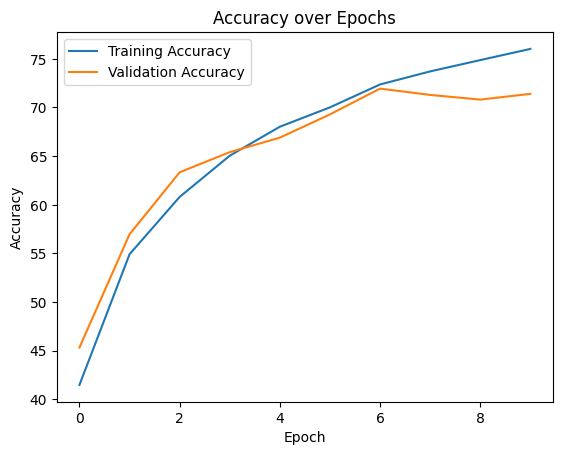

In [39]:
# plot the metric
import matplotlib.pyplot as plt
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} over Epochs')
    plt.show()
plot_metrics(train_loss, val_loss, 'Loss')
plot_metrics(train_acc, val_acc, 'Accuracy')

In [40]:
# test accuracy
for model_name, metrics in results.items():
    if metrics['val_acc'][-1] is not None:
        print(f"\n{model_name} final validation accuracy: {metrics['val_acc'][-1]:.2f}%")
    else:
        print(f"\n{model_name} final validation accuracy: N/A (no labels in validation set)")


resnet18 final validation accuracy: 71.40%


implement AlexNet and mobilenet for comparation

In [41]:
# alexNet 
# initialize the models
import torchvision.models as models

model_alex = models.alexnet(pretrained=True) # pretreain model
model_alex.classifier[6] = nn.Linear(4096, 10)
# use adaptiveavgpool to handle different input sizes
model_alex.features[0] = nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=2)
model_alex.features[12] = nn.AdaptiveAvgPool2d((6, 6))
model_alex=model_alex.to(device)
criterion_alex = nn.CrossEntropyLoss()
optimizer_alex = optim.Adam(model_alex.parameters(), lr=0.001)

train_loss_alex, train_acc_alex, val_loss_alex, val_acc_alex = train_model(model_alex, criterion_alex, optimizer_alex, num_epochs=10)


/home/kubuntu/Desktop/repos/fundamental_ml/fundamental_ml_assignment_2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kubuntu/Desktop/repos/fundamental_ml/fundamental_ml_assignment_2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.8258, Acc: 30.91%, Val Loss: 0.0560, Val Acc: 38.59%
Epoch 2/10, Loss: 1.5938, Acc: 41.29%, Val Loss: 0.0502, Val Acc: 44.11%
Epoch 3/10, Loss: 1.4712, Acc: 47.39%, Val Loss: 0.0457, Val Acc: 51.76%
Epoch 4/10, Loss: 1.3818, Acc: 50.94%, Val Loss: 0.0448, Val Acc: 51.42%
Epoch 5/10, Loss: 1.3123, Acc: 53.43%, Val Loss: 0.0434, Val Acc: 54.29%
Epoch 6/10, Loss: 1.2677, Acc: 55.77%, Val Loss: 0.0417, Val Acc: 55.28%
Epoch 7/10, Loss: 1.2034, Acc: 57.76%, Val Loss: 0.0390, Val Acc: 59.46%
Epoch 8/10, Loss: 1.1717, Acc: 59.41%, Val Loss: 0.0375, Val Acc: 60.43%
Epoch 9/10, Loss: 1.1386, Acc: 60.66%, Val Loss: 0.0385, Val Acc: 60.14%
Epoch 10/10, Loss: 1.1080, Acc: 61.63%, Val Loss: 0.0359, Val Acc: 62.27%


In [42]:
# result of alexNet
results_alex = {
        "train_loss": train_loss_alex,
        "train_acc": train_acc_alex,
        "val_loss": val_loss_alex,
        "val_acc": val_acc_alex
    }
print(results_alex)

{'train_loss': [1.8258346185897485, 1.5937580826183477, 1.471218006298565, 1.3817832820331708, 1.3122595910447092, 1.267744510699385, 1.2034343442977808, 1.171707805734092, 1.1386033997368128, 1.1079543714706128], 'train_acc': [30.915, 41.2925, 47.3875, 50.94, 53.43, 55.77, 57.76, 59.415, 60.6575, 61.635], 'val_loss': [0.05602876658936003, 0.05022515389597863, 0.04574250048439657, 0.0447700902463633, 0.04335658163239118, 0.041706648423199766, 0.039005332890224134, 0.03748740919519203, 0.03854548351349684, 0.03590703745445701], 'val_acc': [38.59, 44.11, 51.76, 51.42, 54.29, 55.28, 59.46, 60.43, 60.14, 62.27]}


implement mobilenet


In [43]:
# transfor the data to match input requirement for mobilenetv2
transform_train_mobilenet = transforms.Compose([
    transforms.Resize((224, 224)),  #resize CIFAR-10 images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test_mobilenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [44]:

# load dataset
train_data_mobilenet = CIFARDataset(img_dir="cifar-10/train", labels_file="cifar-10/trainLabels.csv", transform=transform_train_mobilenet)
test_data_mobilenet = CIFARDataset(img_dir="cifar-10/test", transform=transform_test_mobilenet)


In [45]:
# splite data into train set and validate set 
train_size_mobilenet = int(0.8 * len(train_data_mobilenet))
val_size_mobilenet = len(train_data_mobilenet) - train_size_mobilenet
train_data_mobilenet, val_data_mobilenet = torch.utils.data.random_split(train_data_mobilenet, [train_size_mobilenet, val_size_mobilenet])

In [46]:

trainloader_mobilenet = DataLoader(train_data_mobilenet, batch_size=128, shuffle=True, num_workers=2)
valloader_mobilenet = DataLoader(val_data_mobilenet, batch_size=128, shuffle=False, num_workers=2)
testloader_mobilenet = DataLoader(test_data_mobilenet, batch_size=128, shuffle=False, num_workers=2)

In [47]:
# select mobilenet model
model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, 10)

/home/kubuntu/Desktop/repos/fundamental_ml/fundamental_ml_assignment_2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kubuntu/Desktop/repos/fundamental_ml/fundamental_ml_assignment_2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
model_mobilenet = model_mobilenet.to(device) # send model to device 
criterion_mobilenet = nn.CrossEntropyLoss()
optimizer_mobilenet = optim.Adam(model_mobilenet.parameters(), lr=0.001)

In [49]:
# train the model
train_loss_mobilenet, train_acc_mobilenet, val_loss_mobilenet, val_acc_mobilenet = train_model(
    model_mobilenet, criterion_mobilenet, optimizer_mobilenet, num_epochs=10
)


Epoch 1/10, Loss: 1.0900, Acc: 61.95%, Val Loss: 0.0271, Val Acc: 72.06%
Epoch 2/10, Loss: 0.7769, Acc: 73.55%, Val Loss: 0.0233, Val Acc: 76.59%
Epoch 3/10, Loss: 0.7200, Acc: 75.58%, Val Loss: 0.0229, Val Acc: 76.11%
Epoch 4/10, Loss: 0.6443, Acc: 77.89%, Val Loss: 0.0211, Val Acc: 77.87%
Epoch 5/10, Loss: 0.5907, Acc: 79.75%, Val Loss: 0.0200, Val Acc: 79.29%
Epoch 6/10, Loss: 0.5660, Acc: 80.51%, Val Loss: 0.0190, Val Acc: 80.96%
Epoch 7/10, Loss: 0.5497, Acc: 81.15%, Val Loss: 0.0185, Val Acc: 80.90%
Epoch 8/10, Loss: 0.5235, Acc: 82.14%, Val Loss: 0.0189, Val Acc: 81.06%
Epoch 9/10, Loss: 0.5058, Acc: 82.66%, Val Loss: 0.0169, Val Acc: 82.32%
Epoch 10/10, Loss: 0.4869, Acc: 83.43%, Val Loss: 0.0182, Val Acc: 81.24%


In [50]:
print(f"mobilenet validation accuracy: {val_acc_mobilenet[-1]:.2f}%")

mobilenet validation accuracy: 81.24%
